__Capstone proposal by Valentin__

__CRM Predictions__

# Additional EDA

Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pickle
import itertools

from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

sns.set_style('darkgrid')

We reload our dataset after we have performed changes on the dataset. 

Based on the findings of preliminary EDA, we examined the __colinearity__ of our numerical features. We identified several instances of high colinearity, such as between 'order_amount_3m' and 'order_amount_6m', order amount and order quantity metrics, diversity metrics, and various days metrics. We decided to create new features, choose between colinear features, and pick the most straightforward feature when appropriate to address these concerns.

We redo missing values analysis and replacement from preliminary EDA when applicable.

In [2]:
# Define data types for each variable
dtypes = {
    'days_until_first_order': 'timedelta64[ns]',
    'days_since_acquisition': 'timedelta64[ns]',
    'days_since_last_order': 'timedelta64[ns]'
}

In [3]:
# Load the pickle file and set the data types for each variable
df = pd.read_pickle('./dataset.pkl')
df = df.astype(dtypes)
df.shape

(130000, 85)

In [4]:
# Create a mapping of segment labels to integer values
class_map = {
    'Sleeping Dog': 0,
    'Sleeping Beauty': 1,
    'Low Value Customers': 2,
    'Good Customers': 3,
    'VIP': 4
}

class_names = list(class_map.keys())
class_labels = list(class_map.values())

# 1) Data Cleaning

## a) Unused Columns

### Dates
As part of our feature engineering process, we have identified columns that represent dates and are already present as days intervals. To reduce the complexity of our feature space, we plan to drop these columns.

In addition, we will calculate the age of our customers based on their `birthdate`. By doing so, we can remove the `birthdate` column and use age as a more informative feature for modeling.

In [5]:
def calculate_age_column(df):
    """
    This function calculates age based on the values in 'generation_date' and 'birthdate'
    Replaces unrealistic values of age by NaN
    """
    df = df.copy()  
    # Check that 'birthdate' is not NA before calculating age
    mask = df['birthdate'].notna()
    df.loc[mask, 'age'] = (pd.to_datetime(df['generation_date']) - pd.to_datetime(df['birthdate'])) / pd.Timedelta(days=365)
    
    # Replace age values greater than 100 or lower than 16
    age_mask = (df['age'] > 100) | (df['age'] < 16)
    df.loc[age_mask, 'age'] = np.nan
    
    return df

In [6]:
df = calculate_age_column(df)

In [7]:
def drop_date_columns(df):
    """
    This function drops dates columns that are already present as days intervals.
    """
    columns_to_drop = [
        'acquisition_date',
        'birthdate',
        'first_order_date',
        'last_order_date',
        'last_online_order_date',
        'last_offline_order_date',
        'second_order_date',
        'third_order_date',    
        'fourth_order_date',
        'fifth_order_date',
    ]
    return df.drop(columns_to_drop, axis=1)

In [8]:
df = drop_date_columns(df)

### Targets

To better understand how customer behavior evolves over time, we have generated multiple target labels that capture changes in customer class over different time intervals (3/6/9/12 months). However, to simplify the problem at hand, we will focus on predicting customer class in 12 months.

By doing so, we can restrict our problem to a multi-class classification problem and develop models that are better suited for this specific problem. This will allow us to more effectively capture the underlying patterns in our data and make more accurate predictions about customer behavior over time.

In [9]:
def drop_prediction_columns(df):
    """
    This function drops unused target labels and prediction dates columns
    These columns are not needed for encoding or analysis.
    """
    columns_to_drop = [
        'target_label_3M',
        'prediction_date_3M',
        'target_label_6M',
        'prediction_date_6M',
        'target_label_9M',
        'prediction_date_9M',
        'prediction_date_12M'
    ]
    return df.drop(columns_to_drop, axis=1)

In [10]:
df = drop_prediction_columns(df)

### CustomerID

As part of our feature engineering process, we have decided to remove the `customer_id` and `generation_date` columns from our dataset. The customer ID is not useful as it remains the same across database snapshots.

Instead, we will focus on the customer's status during the `generation_month`. We will keep this column as a potentially relevant time feature in order to capture seasonal trends within the cosmetics industry. Days are too granular a measurement to be used, and years would include yearly seasonality that may not be useful for prediction.

By incorporating the month of prediction into our feature predictions, we can potentially capture important seasonal trends and improve the performance of our models. We have also chosen to start looking at database snapshots after COVID store reopenings to exclude abnormal snapshots that have no offline purchases for a year from our training data.

In [11]:
def convert_month_to_str(df):
    """
    Change values of generation_month from 1,2,3.. to Jan, Feb, Mar
    """
    df = df.copy()  
    df['generation_month'] = df['generation_month'].apply(lambda x: pd.Timestamp(year=2000, month=x, day=1).strftime('%b'))
    return df

In [12]:
df = convert_month_to_str(df)

First, we look at in average how many times the same `customer_id` is used in different `generation_month`

In [13]:
count_df = df.groupby('customer_id').size().reset_index(name='count')

# average time for each customer_id
avg_count = count_df['count'].mean()

print(f"Each customer_id appears on average {avg_count:.2f} times in df.")

Each customer_id appears on average 7.26 times in df.


This seems to be an appropriate amount as we generated more than 2 years of monthly databases snapshots.

In [14]:
def drop_customerid_columns(df):
    """
    This function drops customer_id and generation_date
    """
    columns_to_drop = [
        'customer_id',
        'generation_date'
    ]
    return df.drop(columns_to_drop, axis=1)

In [15]:
df = drop_customerid_columns(df)

## b) Standardization

### Datatypes

 Most data types are float as expected, there is some change to do :
 - on timedelta to harmonize them to float with other `days_` variable.
 - on generation month, to convert it to an object as this column is potentially susceptible to one hot encoding, considering there is no ordinality between months.

In [16]:
def convert_timedelta_columns_to_float(df):
    """
    Convert timedelta64 columns to float columns representing the number of days.
    Convert int days columns to float
    """
    df = df.copy()  
    df['days_until_first_order'] = df['days_until_first_order'].dt.total_seconds() / 86400.0
    df['days_since_acquisition'] = df['days_since_acquisition'].dt.total_seconds() / 86400.0
    df['days_since_last_order'] = df['days_since_last_order'].dt.total_seconds() / 86400.0
    df['days_since_first_order'] = df['days_since_first_order'].astype(float)
    df['days_since_second_order'] = df['days_since_second_order'].astype(float)

    return df

In [17]:
df = convert_timedelta_columns_to_float(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Data columns (total 67 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   language                       130000 non-null  object 
 1   gender                         130000 non-null  object 
 2   recruitment_source             130000 non-null  object 
 3   zip_code                       115269 non-null  object 
 4   city                           114276 non-null  object 
 5   email_domain                   130000 non-null  object 
 6   email_domain_type              130000 non-null  object 
 7   total_orders                   130000 non-null  float64
 8   orders_6m                      85721 non-null   float64
 9   orders_24m                     130000 non-null  float64
 10  order_amount_6m                85721 non-null   float64
 11  order_amount_24m               130000 non-null  float64
 12  total_orders_amount           

Our variable types have been standardized, and we now have only object and float64 types remaining.

### Promo rates

To ensure consistency, we have standardized promotional rates to a range between 0 and 1. This helps to avoid scenarios where the promotional rate exceeds 1, which would otherwise indicate that the price before the discount was higher than the price after the discount.

In [19]:
def reformat_promo_rates(df):
    '''
    This function cleans potential errors in promo rate where it would mean
    that order amount was higher after discount.
    Drops unused columns at the end.
    '''
    # Replace any metric with promo rate in name by 0 if under 0 or by 1 if above 1
    promo_cols = [col for col in df.columns if 'promo_rate' in col and col != 'promo_rate']
    for col in promo_cols:
        df[col] = np.where(df[col] < 0, 0, np.where(df[col] > 1, 1, df[col]))
        # Change value of metric with promo rate in name to 1-promo rate
        # Meaning a promo rate of 0 sign
        df[col] = 1 - df[col]
            
    # More explicit naming for promo columns
    df = df.rename(columns={'promo_rate': 'orders_with_promo_rate', 'order_promo_rate': 'average_order_promo_rate'})
    
    return df

In [20]:
df = reformat_promo_rates(df)

## c) Missing values

### Orders related

Our strategy for handling missing values on orders involves replacing them with 0, which signifies no interaction with orders. We are also incorporating 0 as the default value for order promotional rate columns, as it represents no promotion being applied.

In [21]:
def replace_missing_values_orders(df):
    """
    Replace missing values for float columns that contain 'order' in their names,
    excluding any columns with 'promo_rate' or 'diversity',
    and also including 'sum_opened_email' and 'sum_clicked_email' columns
    """
    excluded_names = ['diversity','weekday','mode']

    order_cols = df.select_dtypes(include=['float']).filter(like='order').columns

    filtered_cols = [col for col in order_cols if not any(excl_name in col for excl_name in excluded_names)]
    
    # Add email interaction columns
    filtered_cols += ['sum_opened_email', 'sum_clicked_email']
    print(filtered_cols)
    # Replace missing values with 0 in filtered columns
    df[filtered_cols] = df[filtered_cols].fillna(0)
    
    return df

In [22]:
df = replace_missing_values_orders(df)

['total_orders', 'orders_6m', 'orders_24m', 'order_amount_6m', 'order_amount_24m', 'total_orders_amount', 'order_amount_1m', 'order_amount_1m_to_3m', 'order_amount_3m_to_6m', 'order_amount_6m_to_12m', 'order_amount_12m_to_18m', 'order_amount_18m_to_24m', 'order_amount_24m_to_36m', 'order_amount_after_36m', 'days_until_first_order', 'days_since_last_order', 'orders_with_promo_rate', 'first_order_total_amount', 'second_order_total_amount', 'third_order_total_amount', 'fourth_order_total_amount', 'fifth_order_total_amount', 'second_order_amount_shift', 'third_order_amount_shift', 'fourth_order_amount_shift', 'fifth_order_amount_shift', 'second_order_days_gap', 'third_order_days_gap', 'order_amount_mean', 'order_amount_std', 'average_order_promo_rate', 'days_since_first_order', 'days_since_second_order', 'days_since_third_order', 'days_since_last_online_order', 'days_since_last_offline_order', 'sum_opened_email', 'sum_clicked_email']


### Age

- To handle missing values in the `age` column:
    - We will replace them with the mean for the corresponding `gender`, `recruitment_source`, and `rfm_label` categories.
    - The recruitment source (online vs. offline) and `rfm_label` category may be indicative of audience differences.
    - In our preliminary EDA, we observed that age groups vary based on `rfm_label`.
- Therefore, we will include `rfm_label` as a factor in our age imputation process.

In [23]:
def replace_missing_age(df):
    '''
    This function replaces missing values in 'age'
    by taking the grouped average of age for 'recruitment_source' and 'gender'.
    '''
    # Group df by 'recruitment_source' and 'gender'
    grouped = df.groupby(['recruitment_source', 'gender', 'rfm_labels'])
    
    # Calculate mean age for each group
    mean_age = grouped['age'].mean()
    
    # Replace missing values in 'age' with corresponding group mean age
    missing_age_mask = pd.isnull(df['age'])
    df.loc[missing_age_mask, 'age'] = df.loc[missing_age_mask].apply(lambda row: mean_age.loc[(row['recruitment_source'], row['gender'], row['rfm_labels'])], axis=1)
     
    # Replace any remaining missing values with overall mean age
    df['age'].fillna(df['age'].mean(), inplace=True)
    
    return df

In [24]:
df = replace_missing_age(df)

### Gender and recruitment_source

Here we replace unrealistic 'nan' values of `gender` and `recruitment_source` by their most common values.

In [25]:
df['gender'].value_counts()

F      85240
U      23785
M      20951
nan       24
Name: gender, dtype: int64

In [26]:
df['recruitment_source'].value_counts()

Offline    94944
Website    31460
Media       3594
nan            2
Name: recruitment_source, dtype: int64

In [27]:
def replace_gender_and_recruitment_source(df):
    '''
    Replace unknow Gender by F, as most customers are 
    '''
    # Replace 'nan' and 'U' values in 'gender' column with 'F'
    df['gender'] = df['gender'].replace(['nan', 'U'], 'F')
    
    # Replace 'nan' values in 'recruitment_source' by 'Offline'
    df['recruitment_source'] = df['recruitment_source'].replace('nan', 'Offline')
    
    return df

In [28]:
df = replace_gender_and_recruitment_source(df)

### Devices

We will replace 'nan', 'unknown', 'proxy', and 'Other' values in the `preferred_device_open` and `preferred_device_click` columns. To do so, we will use the most frequent device value for each email domain and `rfm_label` combination. 

We arrived at this approach after conducting descriptive statistics analysis, which showed that `rfm_label` and email domain are related to preferred devices. It is intuitive that different email domains would correlate with different devices.

In [29]:
def replace_preferred_devices(df):
    '''
    Replace 'nan', 'unknown', 'proxy' string values in preferred_device_open and preferred_device_click columns
    with most frequent value for each column in same email domain.
    '''
    # Replace 'nan' string values with NaN values
    df.replace('nan', np.nan, inplace=True)
    df[['preferred_device_open', 'preferred_device_click']] = df[['preferred_device_open', 'preferred_device_click']].replace(['proxy', 'unknown','Other'], np.nan)

    grouped = df.groupby(['email_domain', 'rfm_labels'])

    # Replace NaN values with the mode for each column in each group
    df['preferred_device_open'] = grouped['preferred_device_open'].apply(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else pd.NA))
    df['preferred_device_click'] = grouped['preferred_device_click'].apply(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else pd.NA))
    
    # Replacing Ipod
    df[['preferred_device_open', 'preferred_device_click']] = df[['preferred_device_open', 'preferred_device_click']].replace(['iPod'], 'iPhone')

    return df

In [30]:
df = replace_preferred_devices(df)

## d) Colinear Columns

We will remove highly correlated columns identified during preliminary EDA, such as `days_since_last_order`. Since this column indicates the number of days since the last order, it may not be relevant for some customers who have not made a purchase in a long time. Additionally, for customers who have made recent purchases, the values may be close together, leading to high collinearity relative to the timeframe.

Before removing highly correlated columns, we will add a new feature: the average number of days between orders. This will provide a more meaningful measure of customer purchasing behavior, and may be useful for modeling.

In [31]:
def add_days_between_orders(df):
    """
    Adds a new column called days_between_orders
    difference between days_since_first_order minus days_since_last_order divided by the total number of orders.
    """
    # Calculate the days between orders, only when both 'days_since_last_order' and 'total_orders' are not na
    df['days_between_orders'] = df.apply(lambda row: (row['days_since_first_order'] - row['days_since_last_order'])/row['total_orders'] 
                                         if pd.notna(row['days_since_first_order']) and pd.notna(row['days_since_last_order']) and pd.notna(row['total_orders']) 
                                         else pd.NA, axis=1)
    
    # Replace negative values with zero, rounding time errors
    df['days_between_orders'] = df['days_between_orders'].apply(lambda x: 0 if x < 0 else x)
    return df

In [32]:
df= add_days_between_orders(df)

In [33]:
df.head()

,language,gender,recruitment_source,zip_code,city,email_domain,email_domain_type,total_orders,orders_6m,orders_24m,...,preferred_device_open,preferred_device_click,target_label_12M,days_since_first_order,days_since_second_order,days_since_third_order,days_since_last_online_order,days_since_last_offline_order,age,days_between_orders
0,de,F,Website,NaN,NaN,other,frdeit_domain,4.0,3.0,4.0,...,iPhone,iPhone,Good Customers,269.0,119.0,89.0,269.0,64.0,31.849315,51.250000
1,de,F,Offline,8193,Eglisau,hotmail.com,international_domain,9.0,1.0,4.0,...,iPhone,iPhone,Good Customers,2898.0,2858.0,1444.0,254.0,22.0,30.991781,319.555556
2,de,F,Offline,8004,ZÜRICH,gmail.com,international_domain,12.0,2.0,5.0,...,iPhone,iPhone,Good Customers,2316.0,2051.0,1859.0,62.0,556.0,43.110994,187.833333
3,fr,F,Website,1991,ARVILLARD,gmail.com,international_domain,5.0,1.0,4.0,...,iPhone,iPhone,Good Customers,740.0,509.0,490.0,54.0,0.0,40.115485,137.200000
4,de,M,Offline,8003,ZÜRICH,gmx.net,international_domain,15.0,3.0,8.0,...,PC,iPhone,Good Customers,1266.0,1255.0,1126.0,0.0,25.0,44.600322,82.733333


Based on our preliminary EDA, we have decided to keep the `days_since_first_order` column. This feature is more straightforward and easier to understand, as it simply indicates the number of days since a customer's first order.

In addition, we have observed that many customers make a purchase on acquisition within our selected classes, making this feature a potentially valuable predictor for modeling customer behavior.

In [34]:
def drop_colinear_days_columns(df):
    """
    This function drops highly colinear days column
    """
    columns_to_drop = [
    'days_since_second_order',
    'days_since_third_order',
    'days_since_acquisition',
    'days_until_first_order'
    ]

    return df.drop(columns_to_drop, axis=1)

In [35]:
df = drop_colinear_days_columns(df)

We will remove columns that were used solely for RFM calculation and are now included in separate, non-overlapping features. For example, we have splitted `order_amount_6m` into `order_amount_1m`, `order_amount_1m_to_3m`, and `order_amount_3m_to_6m`, which represent the order amounts in the past month (at the time of the database snapshot generation), before the past month but not after three months prior, and in the last four to six months prior, respectively.

In addition, we will remove `average_order_promo_rate` since preliminary EDA showed it is highly collinear with `orders_with_promo_rate`. We have chosen to keep `orders_with_promo_rate` as it provides a more straightforward understanding of customer behavior (i.e., what percentage of orders were done during a promotion) as compared to `average_order_promo_rate`, which may not accurately represent highly promotional or non-promotional orders.

In [36]:
def drop_colinear_order_columns(df):
    """
    This function drops highly colinear orders column that are represented now in specific time periods
    """
    columns_to_drop= [
        'total_orders',
        'orders_6m',
        'orders_24m',
        'order_amount_6m',
        'order_amount_24m',
        'average_order_promo_rate'
    ]

    return df.drop(columns_to_drop, axis=1)

In [37]:
df = drop_colinear_order_columns(df)

In [38]:
def find_highest_correlated_columns(df,number_top_correlations):
    """
    Compute correlations from pairs of numerical columns from a dataframe df
    Returns the top number_top_correlations as a list
    Use to investigate ill-conditionning 
    """
    highest_correlated_columns = []
    
    # Iterating over all possible column pairs
    for col1, col2 in itertools.combinations(df.columns, 2):
        # Correlation between pair
        corr = df[col1].corr(df[col2])
        # Add to list
        highest_correlated_columns.append((col1, col2, round(corr,3)))
        # Sorting list by top correlations
        highest_correlated_columns.sort(key=lambda x: x[2], reverse=True)
    
    return highest_correlated_columns[:number_top_correlations]

Note that we keep `total_orders_amount` as it used later to plot outliers using zscore on the log transformed version of the column. It also good to exemplify why we splitted and order_amount columns into different time ranges as it is highly colinear with other columns.

In [39]:
find_highest_correlated_columns(df.select_dtypes(include='number'),30)

[('total_orders_amount', 'order_amount_after_36m', 0.908),
 ('total_orders_amount', 'order_amount_24m_to_36m', 0.755),
 ('second_order_days_gap', 'days_between_orders', 0.67),
 ('second_order_total_amount', 'order_amount_mean', 0.663),
 ('order_amount_mean', 'order_amount_std', 0.659),
 ('first_order_total_amount', 'order_amount_mean', 0.643),
 ('order_amount_after_36m', 'days_since_first_order', 0.603),
 ('total_orders_amount', 'order_amount_18m_to_24m', 0.573),
 ('first_order_total_amount', 'order_amount_std', 0.561),
 ('order_amount_24m_to_36m', 'order_amount_after_36m', 0.551),
 ('total_orders_amount', 'days_since_first_order', 0.548),
 ('third_order_days_gap', 'days_between_orders', 0.541),
 ('total_orders_amount', 'order_amount_12m_to_18m', 0.522),
 ('fourth_order_total_amount', 'fifth_order_total_amount', 0.508),
 ('order_amount_18m_to_24m', 'order_amount_24m_to_36m', 0.506),
 ('second_order_total_amount', 'second_order_amount_shift', 0.494),
 ('third_order_total_amount', 'third

Here, we see that columns that represent the amount of the first to fifth purchase amount as they are already translated through measure like `fourth_order_amount_shift` and the `order_amount_mean`

In [40]:
def drop_colinear_order_rank_amount_columns(df):
    """
    This function drops highly colinear order rank columns 
    """
    columns_to_drop = [
    'first_order_total_amount',
    'second_order_total_amount',
    'third_order_total_amount',
    'fourth_order_total_amount',
    'fifth_order_total_amount'
    ]
    return df.drop(columns_to_drop, axis=1)

In [41]:
df = drop_colinear_order_rank_amount_columns(df)

In [42]:
find_highest_correlated_columns(df.select_dtypes(include='number'),30)

[('total_orders_amount', 'order_amount_after_36m', 0.908),
 ('total_orders_amount', 'order_amount_24m_to_36m', 0.755),
 ('second_order_days_gap', 'days_between_orders', 0.67),
 ('order_amount_mean', 'order_amount_std', 0.659),
 ('order_amount_after_36m', 'days_since_first_order', 0.603),
 ('total_orders_amount', 'order_amount_18m_to_24m', 0.573),
 ('order_amount_24m_to_36m', 'order_amount_after_36m', 0.551),
 ('total_orders_amount', 'days_since_first_order', 0.548),
 ('third_order_days_gap', 'days_between_orders', 0.541),
 ('total_orders_amount', 'order_amount_12m_to_18m', 0.522),
 ('order_amount_18m_to_24m', 'order_amount_24m_to_36m', 0.506),
 ('sum_opened_email', 'sum_clicked_email', 0.437),
 ('total_orders_amount', 'order_amount_6m_to_12m', 0.428),
 ('days_since_first_order', 'days_between_orders', 0.423),
 ('order_amount_6m_to_12m', 'order_amount_mean', 0.412),
 ('bought_body_care', 'bought_soaps', 0.411),
 ('bought_body_care', 'days_since_first_order', 0.409),
 ('order_amount_24m_

# 2) Feature engineering

## a) Categorical

### Gender / Language

Based on initial machine learning tests, we have found that `gender` and `language` are not very useful as one-hot encoded categorical features, and may increase the number of features. To address this issue, we have decided to transform these features into ordinal features.

The logic behind this approach is to look at customer profiles (i.e., combinations of gender and language) and assess whether we observe differences in customer behavior. For example, we may examine whether VIP customers of a certain gender and language combination tend to remain VIP one year later. This approach may be more informative than simply one-hot encoding these features.

In [43]:
df['customer_profile'] = df.apply(lambda x: x['gender'] + '_' + x['language'], axis=1)

In [44]:
pd.options.display.max_rows = None
df['target_label_12M_rank'] = df['target_label_12M'].map(class_map)
df.head()

,language,gender,recruitment_source,zip_code,city,email_domain,email_domain_type,total_orders_amount,order_amount_1m,order_amount_1m_to_3m,...,preferred_device_open,preferred_device_click,target_label_12M,days_since_first_order,days_since_last_online_order,days_since_last_offline_order,age,days_between_orders,customer_profile,target_label_12M_rank
0,de,F,Website,NaN,NaN,other,frdeit_domain,290.88,0.00,148.00,...,iPhone,iPhone,Good Customers,269.0,269.0,64.0,31.849315,51.250000,F_de,3
1,de,F,Offline,8193,Eglisau,hotmail.com,international_domain,610.40,137.60,0.00,...,iPhone,iPhone,Good Customers,2898.0,254.0,22.0,30.991781,319.555556,F_de,3
2,de,F,Offline,8004,ZÜRICH,gmail.com,international_domain,804.92,0.00,46.72,...,iPhone,iPhone,Good Customers,2316.0,62.0,556.0,43.110994,187.833333,F_de,3
3,fr,F,Website,1991,ARVILLARD,gmail.com,international_domain,1053.60,0.00,319.20,...,iPhone,iPhone,Good Customers,740.0,54.0,0.0,40.115485,137.200000,F_fr,3
4,de,M,Offline,8003,ZÜRICH,gmx.net,international_domain,924.64,51.84,0.00,...,PC,iPhone,Good Customers,1266.0,0.0,25.0,44.600322,82.733333,M_de,3


In [45]:
pd.options.display.max_rows = None
df['target_label_12M_rank'] = df['target_label_12M'].map(class_map)
grouped = df.groupby(['customer_profile', 'rfm_labels', 'target_label_12M'])['target_label_12M'].count() / df.groupby(['customer_profile', 'rfm_labels'])['target_label_12M'].count()
grouped = grouped.reset_index(name='relative_frequency')
grouped = grouped[(grouped['rfm_labels'] == 'VIP') & (grouped['customer_profile'].isin(['F_de', 'M_de']))]
grouped

,customer_profile,rfm_labels,target_label_12M,relative_frequency
10,F_de,VIP,Good Customers,0.189088
11,F_de,VIP,Low Value Customers,0.056295
12,F_de,VIP,Sleeping Beauty,0.157153
13,F_de,VIP,Sleeping Dog,0.039827
14,F_de,VIP,VIP,0.557637
50,M_de,VIP,Good Customers,0.218603
51,M_de,VIP,Low Value Customers,0.055121
52,M_de,VIP,Sleeping Beauty,0.144692
53,M_de,VIP,Sleeping Dog,0.025994
54,M_de,VIP,VIP,0.555590


We have observed that the share of VIP customers who speak a certain language may differ based on gender, and that this may also affect whether they remain VIP customers in the future. To address this, we will take the weighted average of the values in our class map, considering the number of records in the `customer_profile` and `rfm_labels` categories.

By using this approach, we hope to capture the nuances of customer behavior more accurately, and to create more informative ordinal features for modeling.

In [46]:
grouped = df.groupby(['customer_profile', 'rfm_labels'])['target_label_12M_rank'].mean().reset_index(name='customer_profile_rating')
df = df.merge(grouped, on=['customer_profile', 'rfm_labels'])
grouped.head(5)

,customer_profile,rfm_labels,customer_profile_rating
0,F_de,Good Customers,2.251536
1,F_de,Low Value Customers,1.409395
2,F_de,VIP,3.067554
3,F_fr,Good Customers,2.181275
4,F_fr,Low Value Customers,1.366180


### Email info

We will apply a similar approach for the `preferred_device_open` and `preferred_device_click` columns, which we will concatenate to create a new feature called `email_behavior`. We will then use the weighted average of the class map values for each `customer_profile` and `rfm_label` category to convert `email_behavior` to a rating, called `email_behavior_rating`.

Similarly, we will apply this approach to the `email_domain` feature, which we have observed during preliminary EDA may distinguish the target by `rfm_label`. By using weighted averages based on the `customer_profile` and `rfm_label` categories, we hope to create more informative ordinal features for modeling.

In [47]:
# Create column that concatenates
df['email_behavior'] = df['preferred_device_open'] + '_' + df['preferred_device_click']

# Group the data by the new columns and 'rfm_labels', and calculate the mean of 'target_label_12M_rank'
grouped_behavior = df.groupby(['email_behavior', 'rfm_labels'])['target_label_12M_rank'].mean().reset_index(name='email_behavior_rating')
grouped_domain = df.groupby(['email_domain', 'rfm_labels'])['target_label_12M_rank'].mean().reset_index(name='email_domain_rating')

# Merge the results back to the original dataframe
df = df.merge(grouped_behavior, on=['email_behavior', 'rfm_labels'])
df = df.merge(grouped_domain, on=['email_domain', 'rfm_labels'])

Now that we have created new ordinal features based on `gender`, `language`, `preferred_device`, and `email_domain`, we can drop the original categorical columns that are no longer needed. By doing so, we can reduce the number of features and improve the efficiency of our models.

In [48]:
columns_to_drop = [
    'gender',
    'language',
    'customer_profile',
    'email_behavior',
    'preferred_device_open',
    'preferred_device_click',
    'email_domain',
    'target_label_12M_rank'
]
df = df.drop(columns_to_drop, axis=1)

## b) Numerical

### Density
We have built using [this json](https://github.com/ganti/swissZIP/blob/main/swissZIP/v4/data/zip.json) on a github and data available on excel on BFS ([by commune statistics](https://www.bfs.admin.ch/bfs/en/home/statistics/catalogues-databases/tables.assetdetail.15864461.html)) two features indexed by zip_code
- The percentage of foreigners living in each postal code, which may be indicative of a cosmopolitan area.
- The population density in each postal code, which may denote an urban or rural setting.

In addition, we have created a new feature called `age_group`, which is used to fill in missing values. This feature groups customers by age range, allowing us to better understand customer behavior based on age. 

In [49]:
def categorize_age(df):
    '''
    Create age groups based on current values of age
    '''
    age_bins = [0, 25, 35, 45, 55, 65, np.inf]
    age_labels = ['0-25', '25-35', '35-45', '45-55', '55-65', '65+']
    df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)
    return df

df = categorize_age(df)

We now use density.csv to add the two features to dataframe

In [50]:
def clean_numeric_data(value):
    if isinstance(value, str):
        return float(value.replace("'", "").replace(",", "."))
    return value

def add_habitat_columns(df):
    """
    Adds habitat_population_density and habitat_foreigners_share columns to the input DataFrame
    based on the 'zip_code' column from 'density.csv' in the current folder. 
    Replaces missing values by average for same age group and same purchase_channel.
    """

    # Load 'density.csv' file from current folder
    density_df = pd.read_csv('density.csv', sep=';', dtype={'zip_code': object})
    
    # Clean 'habitat_population_density' and 'habitat_foreigners_share' columns
    density_df['habitat_population_density'] = density_df['habitat_population_density'].apply(clean_numeric_data)
    density_df['habitat_foreigners_share'] = density_df['habitat_foreigners_share'].apply(clean_numeric_data)

    df = df.merge(density_df, left_on='zip_code', right_on='zip_code', how='left')

    # Replace missing values in 'habitat_population_density' and 'habitat_foreigners_share'
    # with the average for the same age group and same purchase_channel
    df['habitat_population_density'] = df.groupby(['age_group', 'purchase_channel'])['habitat_population_density'].transform(lambda x: x.fillna(x.mean()))
    df['habitat_foreigners_share'] = df.groupby(['age_group', 'purchase_channel'])['habitat_foreigners_share'].transform(lambda x: x.fillna(x.mean()))

    # Replace any remaining missing values with mean
    df['habitat_population_density'].fillna(df['habitat_population_density'].mean(), inplace=True)
    df['habitat_foreigners_share'].fillna(df['habitat_foreigners_share'].mean(), inplace=True)
    return df

In [51]:
df = add_habitat_columns(df)

We can now drop categorical column that have been transformed

In [52]:
columns_to_drop = [
    'city',
    'zip_code',
    'age_group'
]
df = df.drop(columns_to_drop, axis=1)

### Values Shifts

### Normality

Since Logistic Regression is the classification equivalent of Linear Regression, we want to ensure that our features are as normally distributed as possible. To achieve this, we will consider using log or sqrt transformations for our features. These transformations may help to reduce skewness and improve the normality of our features, which can lead to better performance in our models. 

In [53]:
def check_skewness(df):
    """
    Function to check for skewness in a dataframe's columns.
    Plots histograms of the columns to visually inspect skewness.
    Columns with skewness > 1 are potential candidates for transformation.    
    """
    # Number of charts horizontally
    TOTAL_WIDTH = 6
    # Select only numerical columns
    features = list(df.select_dtypes(include='number').columns)
    df_skew = df[features]
                
    # Calculate the number of rows needed to fit all the charts
    total_height = df_skew.shape[1] // TOTAL_WIDTH
    figure_height = df_skew.shape[1] / TOTAL_WIDTH * 2

    # Check if there are any extra columns that don't fit evenly into a full row
    if df_skew.shape[1] % TOTAL_WIDTH != 0:
    # If there are extra columns, we need an additional row
        total_height += 1

    fig, axes = plt.subplots(total_height,
                             TOTAL_WIDTH,
                             figsize=(2*TOTAL_WIDTH,figure_height))
    axes = axes.ravel()


    for i, col in enumerate(df_skew.columns):
        skewness = df[col].skew()
        axes[i].hist(df[col],bins=30)
        # Set the title of the subplot, small labels for readability
        axes[i].set_title(f'{col} {skewness:.2f}',fontdict={'fontsize': 8})
        
    plt.tight_layout()
        
    # Cleaning of unused axes
    for ax in axes.flatten():
        if not ax.has_data():
            ax.remove()
    plt.show()      

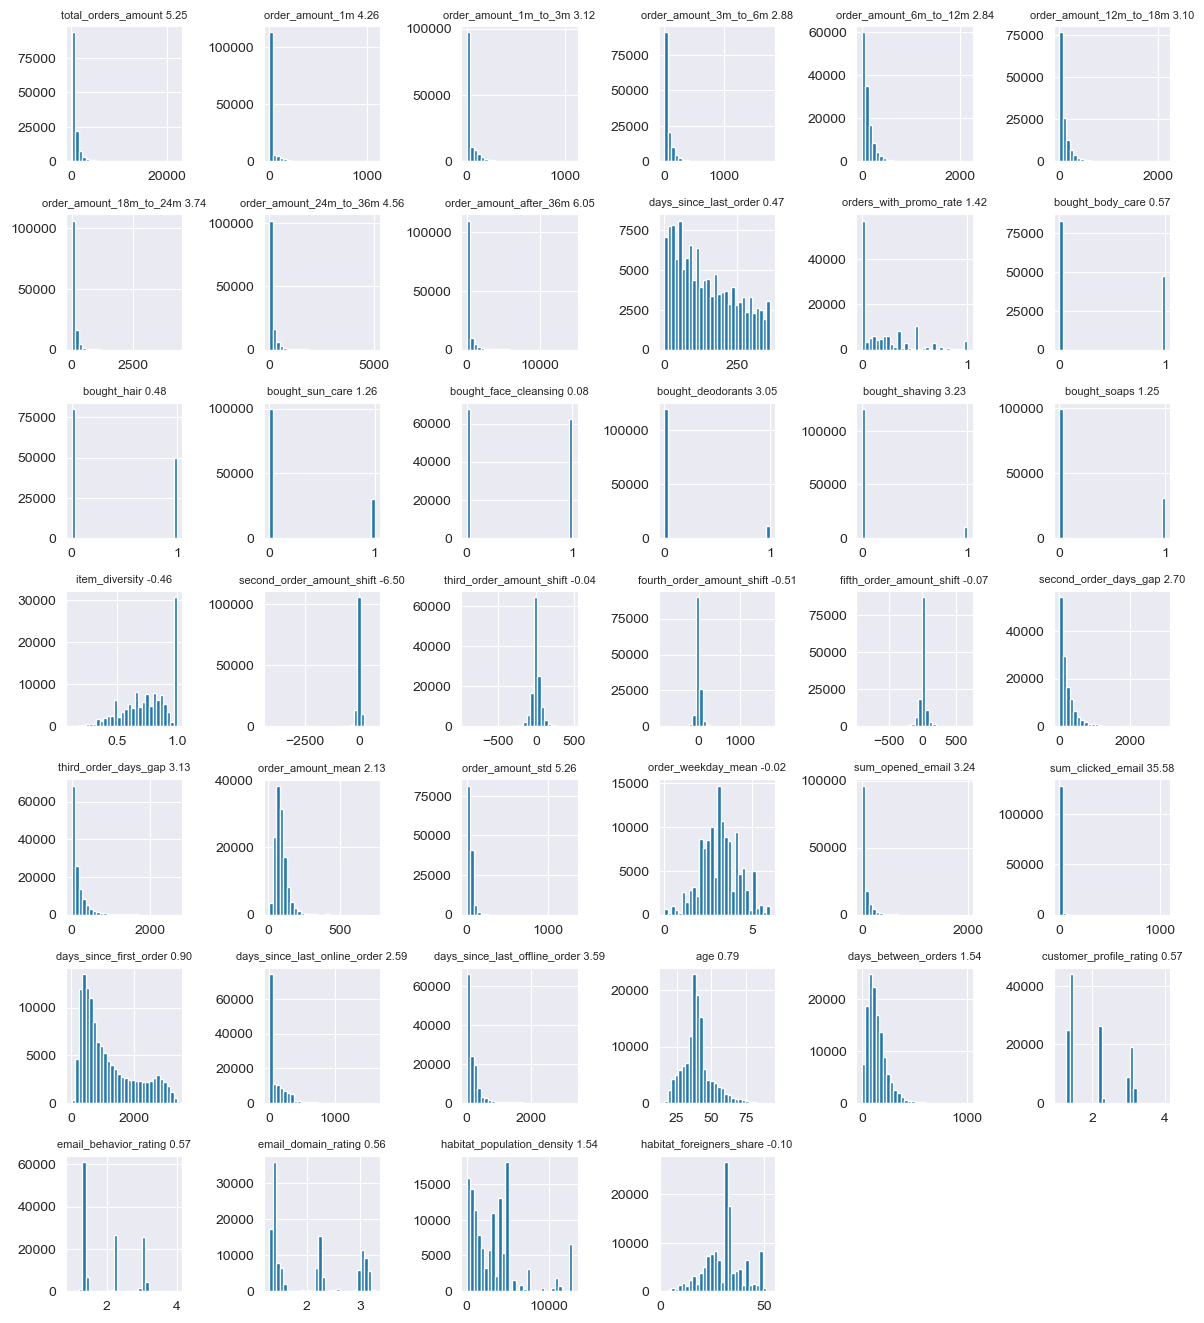

In [54]:
check_skewness(df)

We have found that most of our columns are heavily skewed, which may affect the performance of our models. To address this, we will need to perform feature engineering to improve the normality of our features.

In [55]:
def transform_and_test_normality(df, column):
    # Remove 0 values from the column
    filtered_df = df[df[column] != 0]

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(8, 2))

    axes[0].hist(filtered_df[column], bins=30)
    axes[0].set_title(column, size=10)    
    
    axes[1].hist(np.log1p(filtered_df[column]), bins=40)
    title = 'log1p_' + column
    axes[1].set_title(title, size=10)

    axes[2].hist(np.sqrt(filtered_df[column]), bins=40)
    axes[2].set_title('sqrt_' + column, size=10)
    
    fig.subplots_adjust(hspace=1.5)
    plt.show()


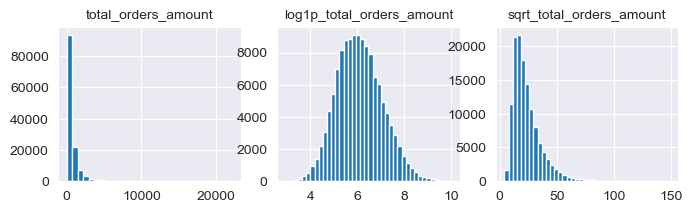

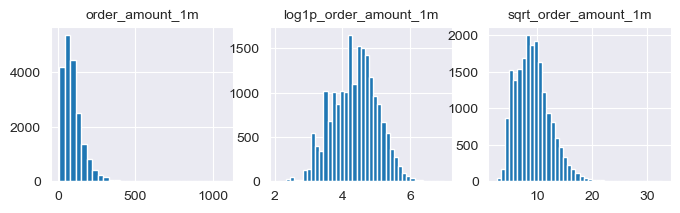

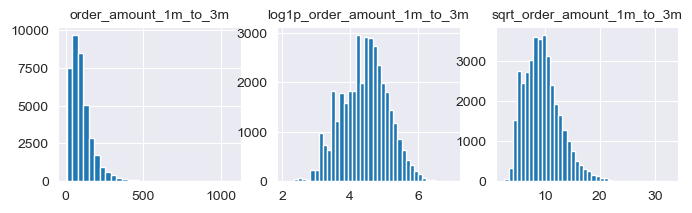

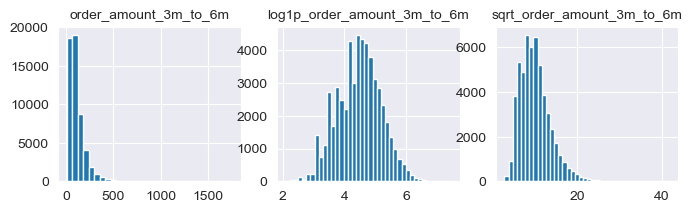

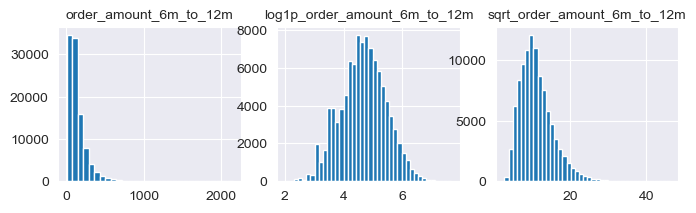

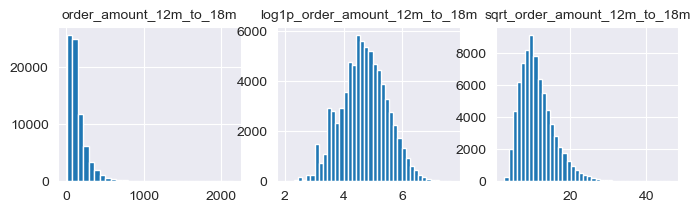

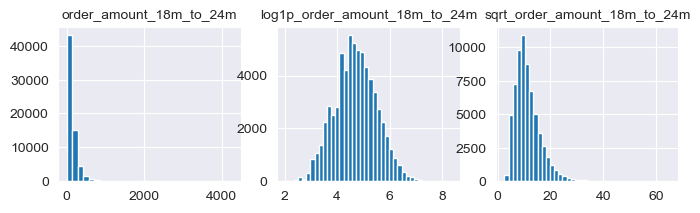

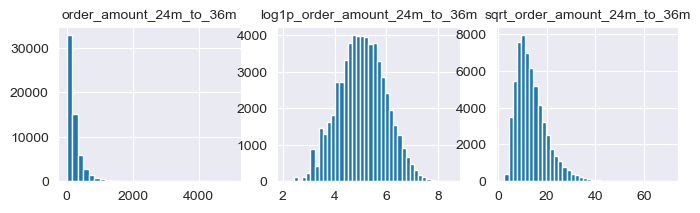

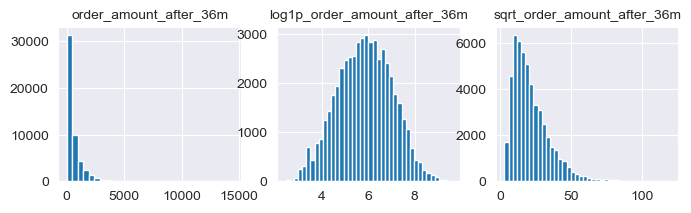

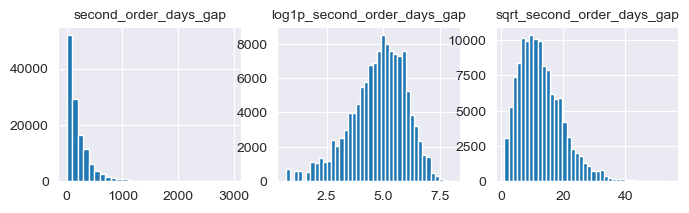

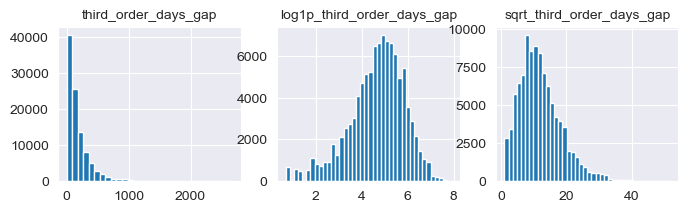

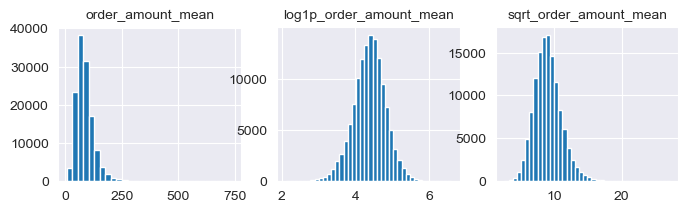

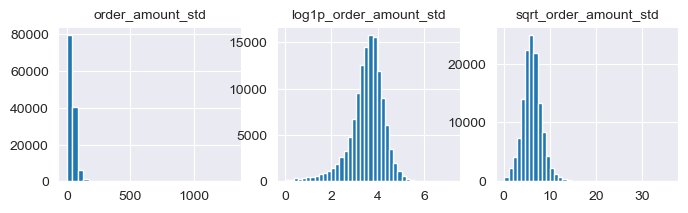

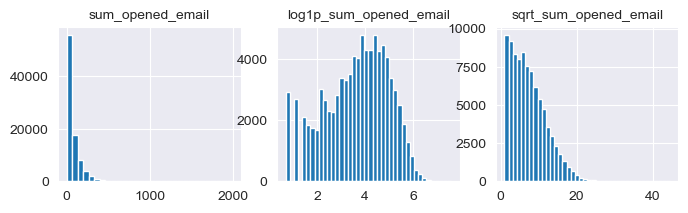

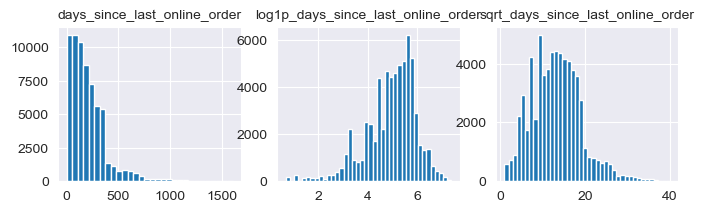

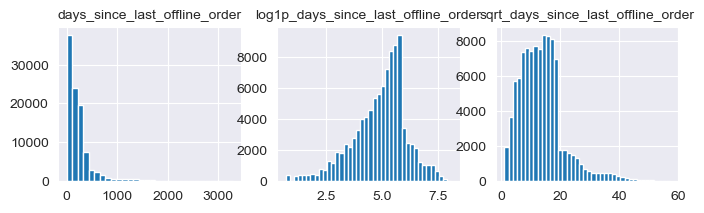

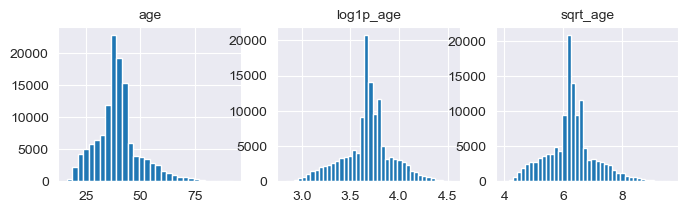

In [56]:
columns = df.columns
log_columns = [
    col for col in columns
    if ('order_amount' in col
        or 'order_days_gap' in col
        or col == 'age'
        or col == 'total_orders_amount'
        or col == 'days_since_last_online_order'
        or col == 'days_since_last_offline_order'
        or col == 'sum_opened_email')
    and 'amount_shift' not in col
]
for col in log_columns:
    transform_and_test_normality(df,col)

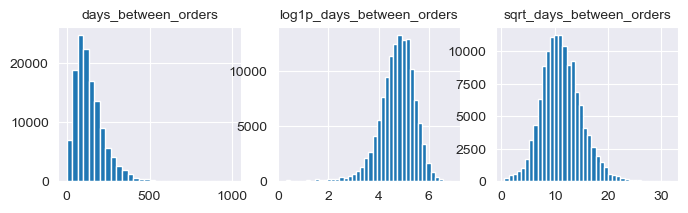

In [57]:
transform_and_test_normality(df,'days_between_orders')

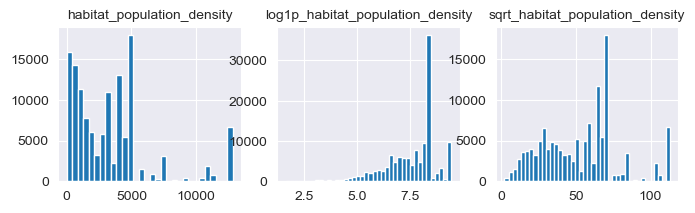

In [58]:
transform_and_test_normality(df,'habitat_population_density')

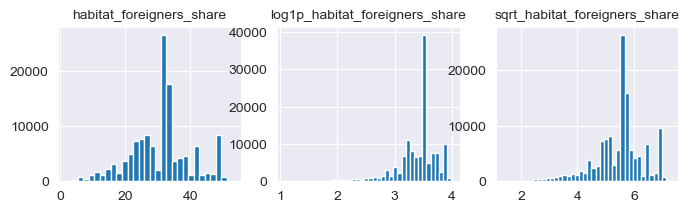

In [59]:
transform_and_test_normality(df,'habitat_foreigners_share')

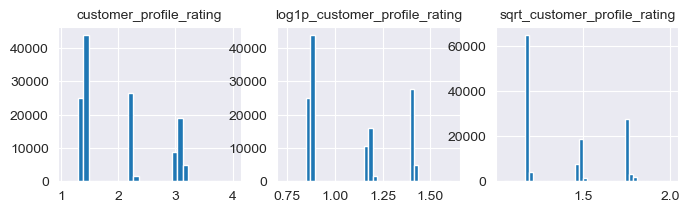

In [60]:
transform_and_test_normality(df,'customer_profile_rating')

Here, we transform columns where it visually increases normality of distribution.

In [61]:
def apply_log_or_sqrt_to_columns(df, log_columns=[], sqrt_columns=[]):
    """
    Apply log1p and sqrt transformations to specified columns
    Returns a dataFrame with transformed columns (prefixed with 'log_' or 'sqrt_') and original columns removed.
    """
    transformed_df = df.copy()
    
    for column in log_columns:
        transformed_df[f'log_{column}'] = np.log1p(transformed_df[column])
        transformed_df.drop(column, axis=1, inplace=True)
        
    for column in sqrt_columns:
        transformed_df[f'sqrt_{column}'] = np.sqrt(transformed_df[column])
        transformed_df.drop(column, axis=1, inplace=True)
        
    return transformed_df

In [62]:
df = apply_log_or_sqrt_to_columns(df,
                                  log_columns=log_columns,
                                  sqrt_columns=['days_between_orders']
                                 )                                

# 3) Relationships

## a) Numerical columns

We redefine a new Color palette for readability in scatter charts.

In [63]:
palette = sns.color_palette()
class_colors_scatters = {
    'Sleeping Dog': palette[3],
    'Sleeping Beauty': palette[9],
    'Low Value Customers': palette[6],
    'Good Customers': palette[8],
    'VIP': palette[2]
}

Here we investigate whether plotting two numerical variables per rfm_label and coloring by target_label helps create a cluster.

In [64]:
def plot_scatterplots_colored_by_target(df, col1, col2):
    """
    Plot subplots of scatter plots for each rfm_label with colored points based on target_label_12M values.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    for i, rfm_label in enumerate(df['rfm_labels'].unique()):
        # Filter dataframe by rfm_label
        subset = df[df['rfm_labels'] == rfm_label]

        # Cutoff of 2% top values to increase readability
        col1_cutoff = subset[col1].quantile(0.98)
        col2_cutoff = subset[col2].quantile(0.98)

        subset = subset[(subset[col1] <= col1_cutoff) & (subset[col2] <= col2_cutoff)]

        # Plot scatter with same color map for all subplots
        sns.scatterplot(
            x=col1,
            y=col2,
            hue='target_label_12M',
            palette=class_colors_scatters,
            s=8,
            alpha=0.8,
            data=subset,
            ax=axes[i],
            legend='brief'
        )

        axes[i].set_title(f"RFM Label: {rfm_label}")
        axes[i].set_xlabel(col1)
        axes[i].set_ylabel(col2)
        axes[i].legend().remove()

    # Set common legend on top of chart
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.005), ncol=len(labels))
    fig.suptitle(f"{col1} vs {col2}", fontsize=14, y=1.05)

    plt.tight_layout()
    plt.show()

__New features__

On the new features, we can say that they are not good at clearly identifying clusters.

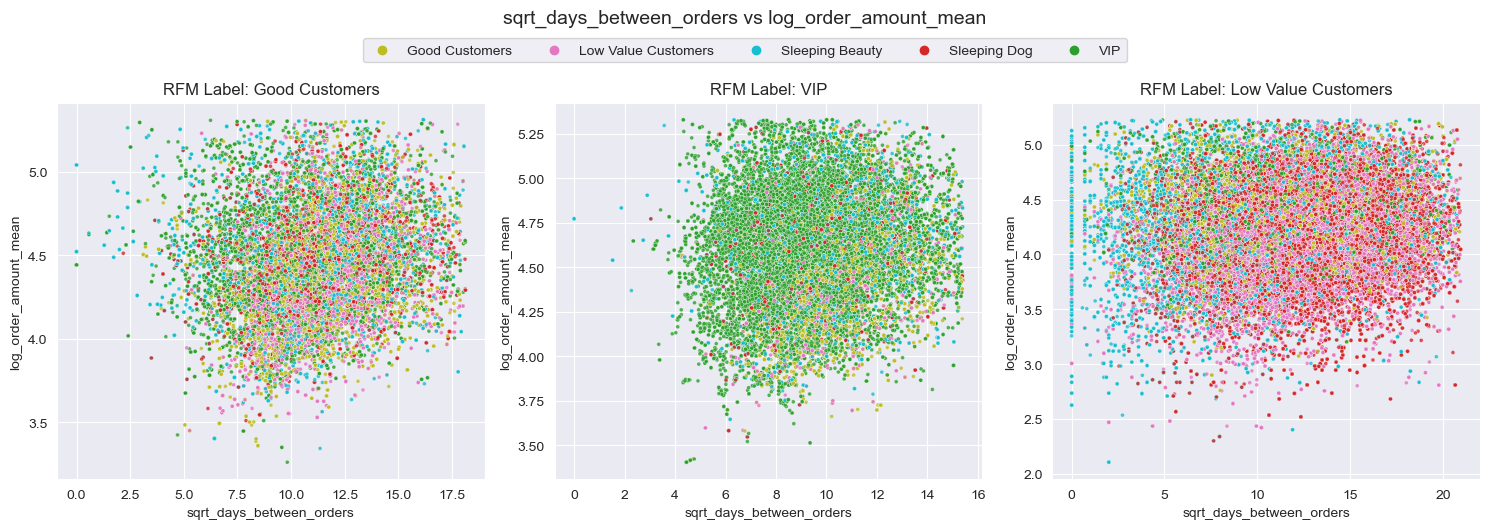

In [65]:
plot_scatterplots_colored_by_target(df, 'sqrt_days_between_orders','log_order_amount_mean')

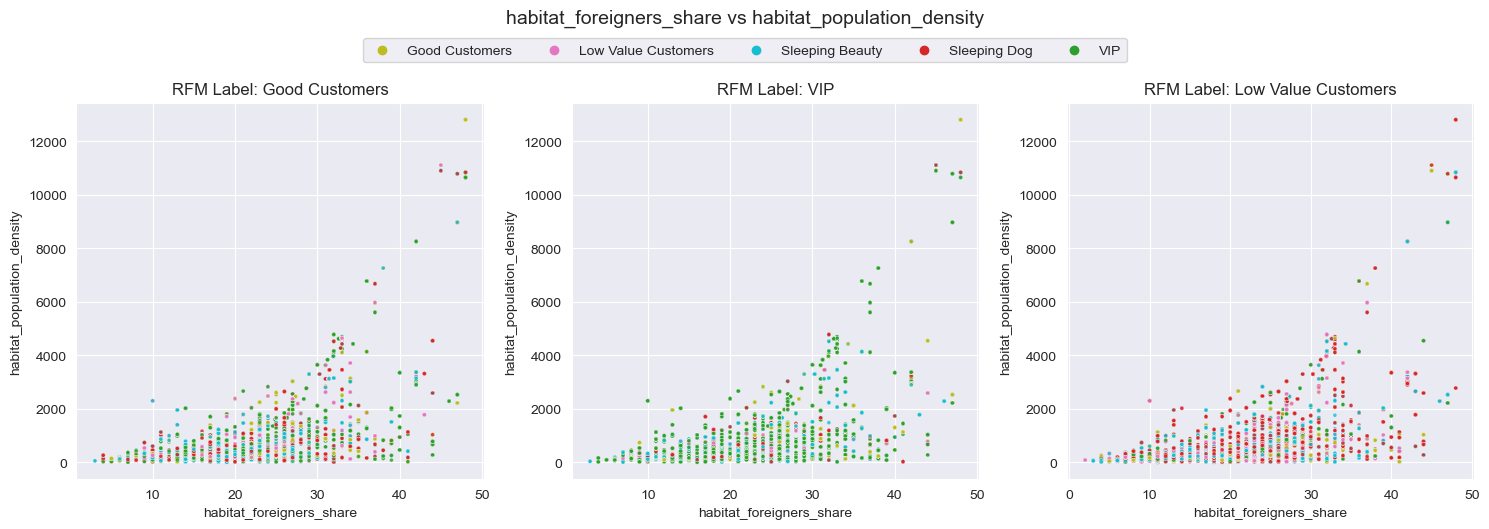

In [66]:
plot_scatterplots_colored_by_target(df, 'habitat_foreigners_share','habitat_population_density')

## b) Pairplot

In [67]:
df = df.rename(columns={'target_label_12M': 'target_label', 'rfm_labels': 'rfm_label'})
df['target_label'] = df['target_label'].map(class_map)

In [68]:
# Calculate correlation between Sale price and other columns
correlations = df.corr()['target_label']
# Top 3 correlations + SalePrice
top_correlations = list(correlations.abs().sort_values(ascending=False).head(5).index)

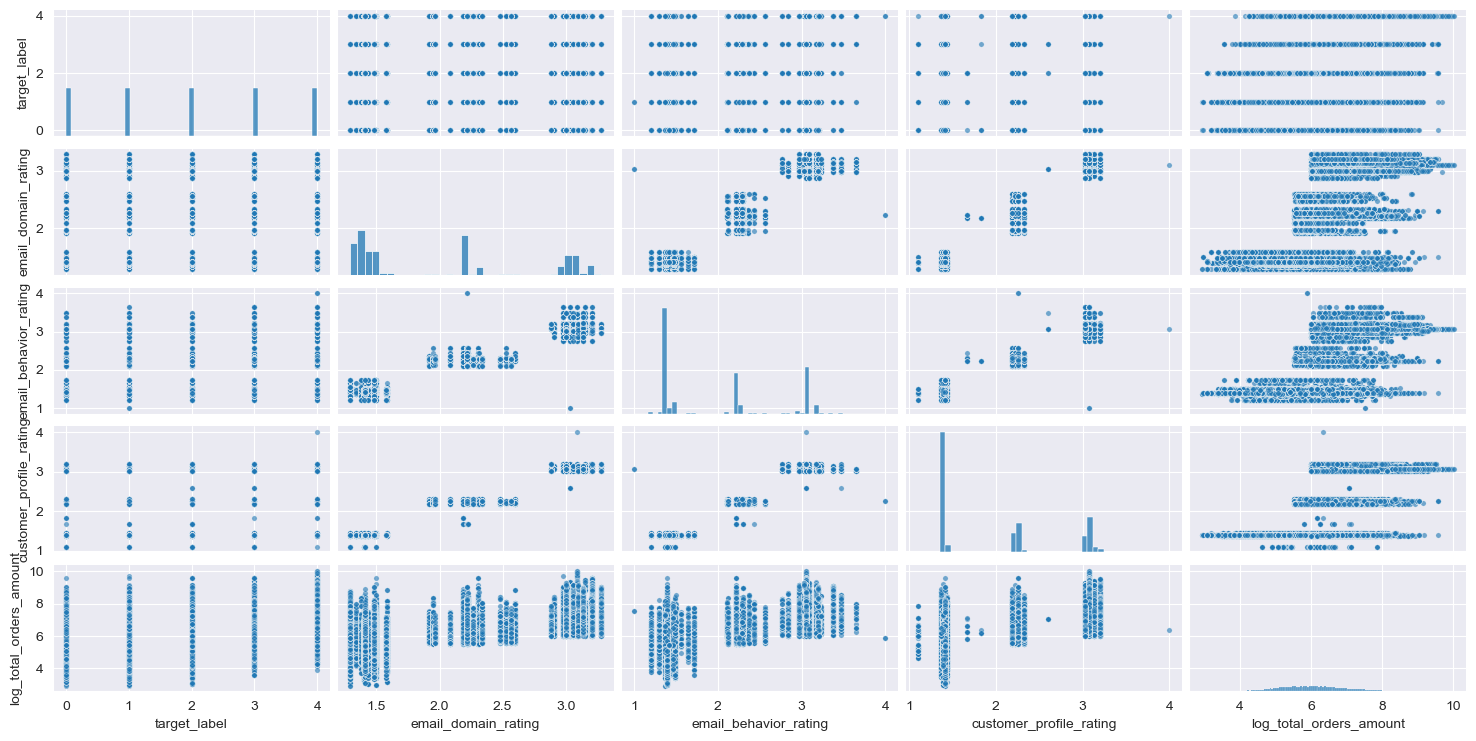

In [69]:
# Create pairplot with only top correlated columns
sns.pairplot(df[top_correlations], height=1.5, aspect=2, 
             plot_kws={'alpha': 0.6, 's': 15})
plt.show()

We have used pairplot to investigate potential relationships or clusters between our features. However, we have found that it is difficult to identify such relationships or clusters using this method.

In particular, we have found that there are no linear relationships between our features, which suggests that more sophisticated modeling techniques may be needed to effectively capture the underlying patterns in our data.

# 4) Outliers
## a) Log Total orders amount

We initialize a column named 'outlier' to be able to flag and count outliers. 

In [70]:
df["outlier"] = 0

In [71]:
def plot_hist_by_rfm_label(df, column, number_zscore):
    """
    Creates a histogram for each value of 'rfm_label'
    Adds vertical lines for 'number_zscore' z-scores on each histogram
    Plots histograms in order of increasing mean of 'df[column]' for each 'rfm_label'
    """
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8), tight_layout=True)
    axes = axes.ravel()

    # Get unique values of 'rfm_labels' and their mean 'df[column]' values
    unique_labels = df.groupby('rfm_label')[column].mean().sort_values(ascending=False).index

    # For every value of 'rfm_label' plot a histogram
    for i, rfm_label in enumerate(unique_labels):
        # Extracting data for current 'rfm_label'
        data = df[df['rfm_label'] == rfm_label][column]

        axes[i].hist(data, bins=50, alpha=0.7)

        axes[i].set_title(rfm_label)
        axes[i].set_xlabel(column)

        # Adding vertical red lines for 'number_zscore' z-scores
        # This indicates visually where we would remove outliers
        mean = np.mean(data)
        std = np.std(data)
        axes[i].axvline(x=mean + number_zscore*std, color='red', alpha=0.3)
        axes[i].axvline(x=mean - number_zscore*std, color='red', alpha=0.3)

    fig.suptitle(f'Histogram of {column} by RFM Label', fontsize=14, y=1.005)
    
    for ax in axes.flatten():
        if not ax.has_data():
            ax.remove()
    plt.show()

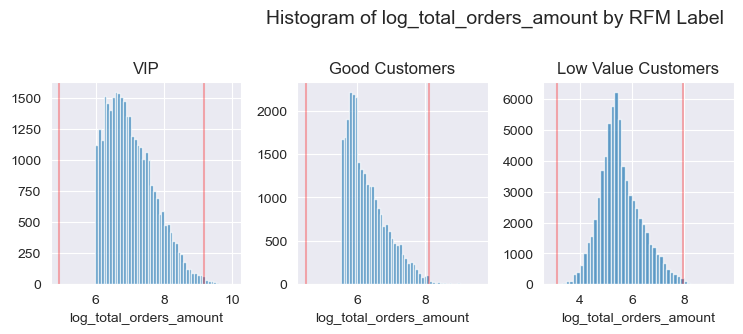

In [72]:
plot_hist_by_rfm_label(df, 'log_total_orders_amount', 3)

Based on this visual inspection, it makes sense to exclude outliers on the right side of the distribution. We will do this overall afterwards.

In [73]:
columns_to_drop = [
    'log_total_orders_amount'
]
df = df.drop(columns_to_drop, axis=1)

## b) Generating train and test datasets

Before identifying outliers, we split our dataset into train and test datasets and save them as pickle to be used afterwards in machine learning models notebooks.

From [course](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v3/subjects/decision-trees-and-svms-v4/units/post-modeling-analysis-for-classifiers-v2)
> While this topic is outside of the scope of our program, it would now also be possible to use all of these predictions and train a new “meta” classifier model on them. Scikit-learn provides multiple such ensemble approaches, most notably the VotingClassifier or the StackingClassifier.

In stacking, we train a meta-model (also known as a second-level model) on the predictions of the base models (first-level models). The idea is that the meta-model learns how to best combine the predictions of the base models to make a final prediction.

This is why we chose to split our training data into two parts: the first part for training the base models and the second part for training the meta-model.
We will use predictions from base models as input features and the true labels as output to train the meta-model.

In [74]:
# Apply one-hot encoding to categorical features
df_encoded = pd.get_dummies(df.copy())

In [75]:
# Move target label column to be last column in df
cols = list(df_encoded.columns)
cols.remove('target_label')
cols.append('target_label')
df_encoded = df_encoded[cols]

# Split dataframe into train and test sets
X = df_encoded.iloc[:, :-1].values
y = df_encoded.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Split train set into base and meta sets
X_train, X_train_meta, y_train, y_train_meta = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

columns = df_encoded.columns

# Save test set as a pickle file
testset = {
    'X_test': X_test,
    'y_test': y_test,
    'random_state': 0
}
with open('testset.pkl', 'wb') as f:
    pickle.dump(testset, f)

# Save train set for base models as a pickle file
trainset_base = {
    'X_train': X_train,
    'y_train': y_train,
    'random_state': 0
}
with open('trainset_base.pkl', 'wb') as f:
    pickle.dump(trainset_base, f)

# Save train set for meta model as a pickle file
trainset_meta = {
    'X_train': X_train_meta,
    'y_train': y_train_meta,
    'random_state': 0
}
with open('trainset_meta.pkl', 'wb') as f:
    pickle.dump(trainset_meta, f)

# Save column names
with open('columns.pkl', 'wb') as f:
    pickle.dump(df_encoded.columns, f)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled.shape

(63700, 83)

## c) Outliers detection

We would like to investigate other outliers detection methods such as found in [this article](https://towardsdatascience.com/detecting-outliers-with-simple-and-advanced-techniques-cb3b2db60d03). It could be an interesting endeavour to investigate those outliers detection techniques, also looking at [scikit learn doc](https://scikit-learn.org/stable/modules/outlier_detection.html#overview-of-outlier-detection-methods)

We plan to test two outlier detection techniques – Local Outlier Factor (LOF) and Isolation Forest – with conservative parameters. We have limited practical knowledge of these techniques and limited implementation experience, so we believe a conservative approach is best at this stage. Additionally, we will continue to use the z-score method to identify outliers based on the log of total order amount.

After identifying potential outliers, we will test different techniques for excluding them from our dataset to see which approach yields the best performance on our test data. Specifically, we will aim to reduce overfitting – keeping it around 10% difference in F1 weighted score between the training and validation sets – while maintaining good performance on the test data. 

__Zscore__

We start by identifying zscore as displayed previously on graph on log_total_order_amount. We have seen before that log total amount is looks normally distributed.

In [76]:
X_train_df = pd.DataFrame(X_train, columns=df_encoded.columns[:-1])

# Select columns to sum
selected_columns = [
    "log_order_amount_1m",
    "log_order_amount_1m_to_3m",
    "log_order_amount_3m_to_6m",
    "log_order_amount_6m_to_12m",
    "log_order_amount_12m_to_18m",
    "log_order_amount_18m_to_24m",
    "log_order_amount_24m_to_36m",
    "log_order_amount_after_36m",
]

# Sum all columns and recreate a dataframe
X_train_df["sum_amount"] = X_train_df[selected_columns].sum(axis=1)
X_train_sumamount = X_train_df[["sum_amount"]].copy() 

# Calculate mean and standard deviation 
mean_sum_amount = X_train_sumamount["sum_amount"].mean()
std_sum_amount = X_train_sumamount["sum_amount"].std()

# Create 'X_train_outliers_zscore' column by applying z-score
# only on right side as we want to keep low amount orders
X_train_sumamount["X_train_outliers_zscore"] = np.where(
    X_train_sumamount["sum_amount"] > mean_sum_amount + 3 * std_sum_amount,
    1,
    0,
)

# Convert back to an array and rename
X_train_outliers_zscore = X_train_sumamount["X_train_outliers_zscore"].to_numpy()

__Local Outlier Factor (LOF)__
[scikit doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

> The strength of the LOF algorithm is that it takes both local and global properties of datasets into consideration: it can perform well even in datasets where abnormal samples have different underlying densities. The question is not, how isolated the sample is, but how isolated it is with respect to the surrounding neighborhood.

We keep standard settings as we have limited experience with this outlier identification technique

In [77]:
# Fit Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.03)
lof.fit(X_train_scaled)

# Predict outliers
lof_outliers = lof.fit_predict(X_train_scaled)

# Create array equal to 1 when outlier
X_train_outliers_lof = np.where(lof_outliers == -1, 1, 0)

__Isolation Forest__ [scikit doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)
> One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The ensemble.IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

We keep standard settings as we have limited experience with this outlier identification technique

In [78]:
# Fit a PCA and transform X_train_scaled
pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

# Fit Isolation Forest
iforest = IsolationForest()
iforest.fit(X_train_pca)

# Predict outliers
iforest_outliers = iforest.predict(X_train_pca)

# Create array equal to 1 when outlier
X_train_outliers_iforest = np.where(iforest_outliers == -1, 1, 0)

__Counting outliers__

We inspect how common are outliers based on the different methods to know whether they can be complementary.

In [79]:
# Number of outliers marked by each method
num_outliers_iforest = np.sum(X_train_outliers_iforest)
num_outliers_lof = np.sum(X_train_outliers_lof)
num_outliers_zscore = np.sum(X_train_outliers_zscore)

print(f"Number of outliers iForest: {num_outliers_iforest}")
print(f"Number of outliers LOF: {num_outliers_lof}")
print(f"Number of outliers Z-score: {num_outliers_zscore}")

# Calculate number of common outliers between each pair of methods
common_outliers_iforest_lof = np.sum((X_train_outliers_iforest == 1) & (X_train_outliers_lof == 1))
common_outliers_iforest_zscore = np.sum((X_train_outliers_iforest == 1) & (X_train_outliers_zscore == 1))
common_outliers_lof_zscore = np.sum((X_train_outliers_lof == 1) & (X_train_outliers_zscore == 1))

# Calculate percentage of same records marked as outliers over the total number of outliers for each pair of methods
perc_common_iforest_lof = common_outliers_iforest_lof / (num_outliers_iforest + num_outliers_lof - common_outliers_iforest_lof) * 100
perc_common_iforest_zscore = common_outliers_iforest_zscore / (num_outliers_iforest + num_outliers_zscore - common_outliers_iforest_zscore) * 100
perc_common_lof_zscore = common_outliers_lof_zscore / (num_outliers_lof + num_outliers_zscore - common_outliers_lof_zscore) * 100


# Print percentage of common outliers between each pair of methods
print(f"iForest and LOF: {perc_common_iforest_lof:.2f}%")
print(f"iForest and Z-score: {perc_common_iforest_zscore:.2f}%")
print(f"LOF and Z-score: {perc_common_lof_zscore:.2f}%")

Number of outliers iForest: 1440
Number of outliers LOF: 1911
Number of outliers Z-score: 457
iForest and LOF: 16.96%
iForest and Z-score: 4.17%
LOF and Z-score: 1.07%


Based on these results, it appears that the different outlier exclusion methods are somewhat complementary, with some overlap but also some unique outliers identified by each method.

For example, the Isolation Forest and LOF methods identified a similar number of outliers, with only a moderate amount of overlap between the two methods. This suggests that while there is some overlap in the outliers detected, each method may also identify unique outliers that the other method misses.

Similarly, there was relatively little overlap between the iForest and Z-score methods, and between the LOF and Z-score methods. This further supports the idea that each method may be identifying unique outliers that the other methods are missing.

Overall, these results suggest that using multiple outlier exclusion methods in combination may be a useful approach to ensure that all potential outliers are captured and excluded from our dataset.

__Saving as pickle__

We save our different arrays of outliers to pickle, to be able to reload them in machine learning workbooks and try them using pipeline.

In [80]:
# Create conservative array
X_train_outliers_conservative = np.where(
    (X_train_outliers_zscore == 1) | ((X_train_outliers_iforest == 1) & (X_train_outliers_lof == 1)),
    1,
    0
)

X_train_outliers_aggressive = np.where(
    (X_train_outliers_zscore == 1) | (X_train_outliers_iforest == 1) | (X_train_outliers_lof == 1),
    1,
    0
)

outliers_dict = {
    "conservative": X_train_outliers_conservative,
    "aggressive": X_train_outliers_aggressive,
    "lof": X_train_outliers_lof,
    "iforest": X_train_outliers_iforest
}

# Save using a dictionary all arrays
with open("outliers.pkl", "wb") as f:
    pickle.dump(outliers_dict, f)

# 5) PCA

As part of our additional EDA, we have fit a Principal Component Analysis (PCA) to our dataset. PCA is a common technique for dimensionality reduction that can help us identify which features are most important in explaining the variance in our data.

By using PCA, we can transform our high-dimensional feature space into a lower-dimensional space while still retaining much of the original variance in the data. We can then explore how well the reduced feature space captures the underlying patterns in our data.

To do this, we fit a PCA model and examined how well it performs in explaining the variance in our dataset with a few sets of components. This can help us identify which components are most important in explaining the variance in our data and potentially improve the performance of our models by reducing the dimensionality of our feature space.

In [81]:
pca = PCA(n_components=None)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

__Scree plot__

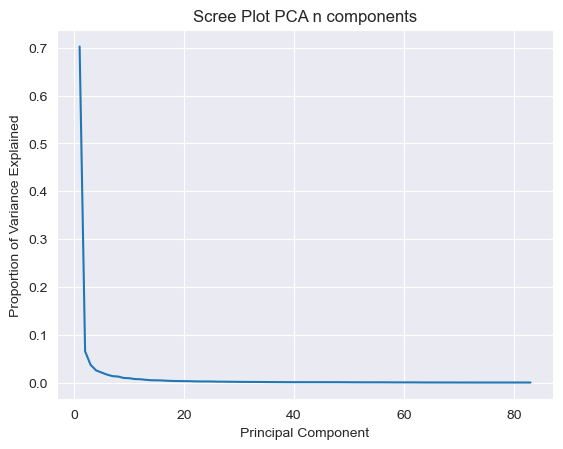

In [82]:
variance_ratios = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(variance_ratios)

plt.plot(
    np.arange(1, len(variance_ratios) + 1),
    variance_ratios
)

plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot PCA n components')
plt.show()

In [83]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    num_components = np.where(cumulative_variance >= threshold)[0][0] +1
    print(f'{threshold * 100}% variance explained by {num_components} components')

10.0% variance explained by 1 components
20.0% variance explained by 1 components
30.0% variance explained by 1 components
40.0% variance explained by 1 components
50.0% variance explained by 1 components
60.0% variance explained by 1 components
70.0% variance explained by 1 components
80.0% variance explained by 3 components
90.0% variance explained by 9 components
95.0% variance explained by 18 components


__Actual scree plot__

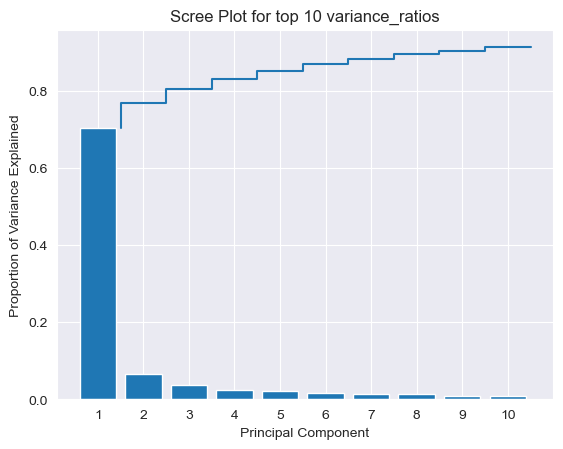

In [84]:
x = np.arange(1, 11)
plt.xticks(x)

plt.bar(x, variance_ratios[:10])

plt.step(x+.5,cumulative_variance[:10])

plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot for top 10 variance_ratios')
plt.show()

__Factor Loading__

In [85]:
# Create DataFrame with variance and principal components
results_df2 = pd.DataFrame(
    {
        "1st component": pca.components_[0],
        "2nd component": pca.components_[1],
    }
).set_index(columns[:-1])

# Sort DataFrame by the coefficients of the 1st loading vector
results_df2.sort_values("1st component", ascending=False).head(10)

,1st component,2nd component
fourth_order_amount_shift,0.111599,0.012649
sum_clicked_email,0.002709,0.987972
habitat_foreigners_share,0.001874,-0.028876
log_age,0.001480,0.050880
order_weekday_mean,0.001055,0.017010
habitat_population_density,0.000778,-0.022045
rfm_label_Low Value Customers,0.000772,-0.026431
purchase_channel_offline,0.000681,-0.033196
bought_shaving,0.000548,0.000811
email_domain_type_international_domain,0.000453,-0.011493


__Visualization__

In [86]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_train_pca)

KMeans(n_clusters=5, random_state=0)

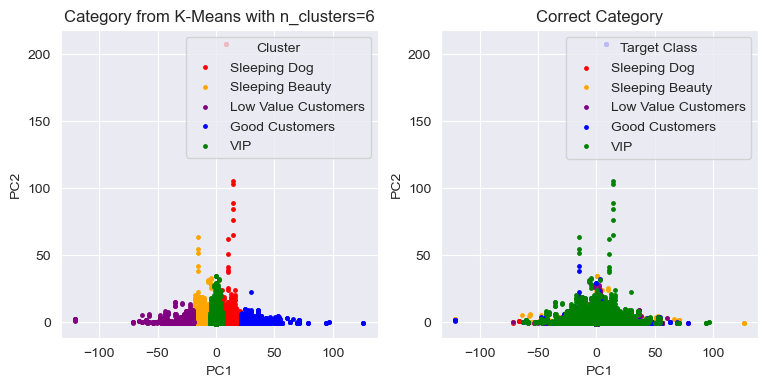

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

colors = ['red', 'orange', 'purple', 'blue', 'green']

# First, plot labels obtained with K-means
for i, color in enumerate(colors):
    # Filter based on cluster labels assigned by k-means
    x1 = X_train_pca[kmeans.labels_ == i, 0]
    y1 = X_train_pca[kmeans.labels_ == i, 1]
    axs[0].scatter(x1, y1, s=6, color=color, label=class_names[i])
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].legend(title='Cluster')
axs[0].set_title('Category from K-Means with n_clusters=6')

# Correct target category values
for i, color in enumerate(colors):
    # Filter according to target values
    x2 = X_train_pca[y_train == i, 0]
    y2 = X_train_pca[y_train == i, 1]
    axs[1].scatter(x2, y2, s=6, color=color, label=class_names[i])
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].legend(title='Target Class')
axs[1].set_title('Correct Category')

plt.show()

We have attempted to visually identify clusters in our data by plotting a scatter plot against two principal components generated by a PCA. However, we have not been able to visually identify any clear clusters based on our classes.

We also applied the K-means clustering algorithm with 5 clusters to our data, but the resulting clusters did not match the distribution of our actual classes. This is in line with our earlier finding that there are no clear linear relationships between our features.

These results suggest that there may be more complex underlying patterns in our data that cannot be captured by simple clustering algorithms or linear relationships between our features.

# 6) Baseline

## Most frequent

In [88]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Create a DummyClassifier with the strategy "most_frequent"
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit dummy classifier
dummy_clf.fit(X_train, y_train)

# Make predictions
y_pred_dummy = dummy_clf.predict(X_test)

# Calculate accuracy
accuracy_dummy = dummy_clf.score(X_test, y_test)
print("Accuracy of the baseline (most frequent class): {:.2f}%".format(accuracy_dummy * 100))

print(classification_report(y_test, y_pred_dummy, zero_division=1))

Accuracy of the baseline (most frequent class): 20.06%
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      7803
           1       0.20      1.00      0.33      7823
           2       1.00      0.00      0.00      7800
           3       1.00      0.00      0.00      7740
           4       1.00      0.00      0.00      7834

    accuracy                           0.20     39000
   macro avg       0.84      0.20      0.07     39000
weighted avg       0.84      0.20      0.07     39000



## Uniform

In [89]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

dummy_clf = DummyClassifier(strategy='uniform')

# Fit dummy classifier
dummy_clf.fit(X_train, y_train)

# Make predictions
y_pred_dummy = dummy_clf.predict(X_test)

# Calculate accuracy
accuracy_dummy = dummy_clf.score(X_test, y_test)
print("Accuracy of the baseline (most frequent class): {:.2f}%".format(accuracy_dummy * 100))

print(classification_report(y_test, y_pred_dummy, zero_division=1))

Accuracy of the baseline (most frequent class): 20.07%
              precision    recall  f1-score   support

           0       0.19      0.19      0.19      7803
           1       0.20      0.20      0.20      7823
           2       0.20      0.20      0.20      7800
           3       0.20      0.21      0.20      7740
           4       0.20      0.20      0.20      7834

    accuracy                           0.20     39000
   macro avg       0.20      0.20      0.20     39000
weighted avg       0.20      0.20      0.20     39000



## No changes

In [90]:
labels_of_interest = ['rfm_label_Good Customers', 'rfm_label_Low Value Customers', 'rfm_label_VIP']

# Initialize an empty array for y_test_rfm_labels
y_test_rfm_labels = np.zeros(X_test.shape[0])

for label in labels_of_interest:
    # Find column index corresponding current label
    column_index = columns.get_loc(label)
    
    # Select corresponding column from X_test
    column = X_test[:, column_index]
    
    # Convert values based on class_map
    column = column * class_map[label.split('_')[-1]]
    
    # Add converted column to y_test_rfm_labels
    y_test_rfm_labels += column

# Ensure resulting array has integer values
y_test_rfm_labels = y_test_rfm_labels.astype(int)

print(classification_report(y_test, y_test_rfm_labels, target_names=class_map.keys(), zero_division=1))

                     precision    recall  f1-score   support

       Sleeping Dog       1.00      0.00      0.00      7803
    Sleeping Beauty       1.00      0.00      0.00      7823
Low Value Customers       0.28      0.75      0.41      7800
     Good Customers       0.32      0.35      0.34      7740
                VIP       0.56      0.70      0.62      7834

           accuracy                           0.36     39000
          macro avg       0.63      0.36      0.27     39000
       weighted avg       0.63      0.36      0.27     39000



This is inline with what has been seen in prelimnary EDA, VIP are the best predicted by this dummy.

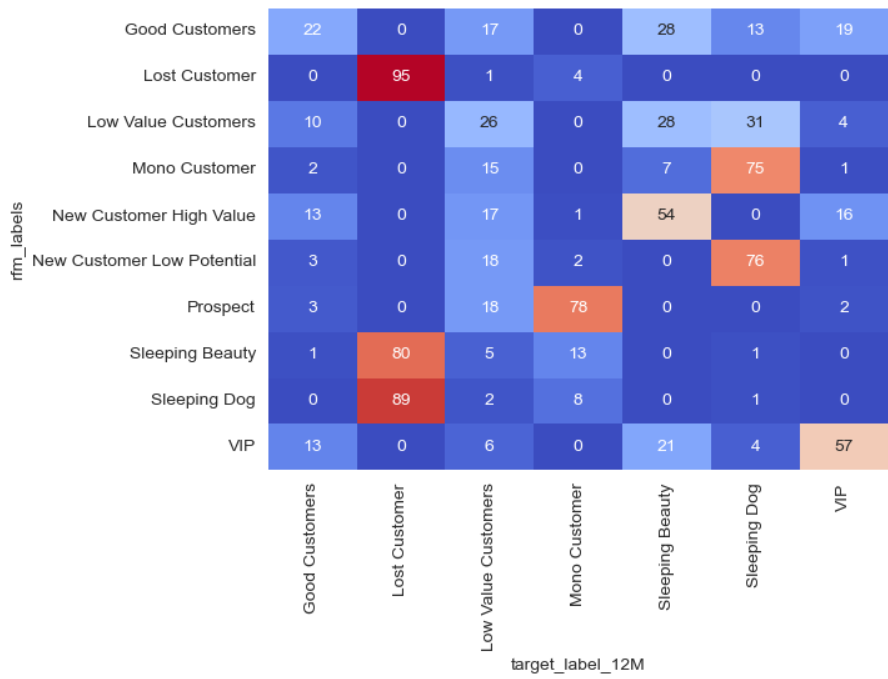

In [91]:
Image(filename='dummy_nochanges.png', width=600, height=600)

As this baseline achieves best weighted f1, we chose this baseline for our project.